In [6]:
# %pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment

# Install and import 

In [5]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets, metrics
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from os import path
from skimage import filters
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.family"] = "sans-serif"
# plt.plot(range(2))

In [2]:
estimated_parameters_df = pd.read_csv(
    "wo_flatfield_estimated_parameters_df_with_autotune.csv", index_col=0
)

In [3]:
estimated_parameters_df.head()

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu,deviation,entropy,fourier_L0_norm,autotune_cost
0,0,10,30,10,biased,0,0,ladmap,0.100000,12.788740,NaN,0.039185,2.035007,0.329701,11.926041
1,0,10,30,10,biased,0,0,ladmap,0.261016,1.134672,NaN,0.033143,2.041676,0.150249,6.549148
2,0,10,30,10,biased,0,0,ladmap,0.681292,0.936035,NaN,0.023936,2.054167,0.017933,2.592150
3,0,10,30,10,biased,0,0,ladmap,1.778279,0.949724,NaN,0.014436,2.068040,0.000249,2.075512
4,0,10,30,10,biased,0,0,ladmap,4.641589,1.035547,NaN,0.009749,2.081444,0.000000,2.081444


# Calculate deviation

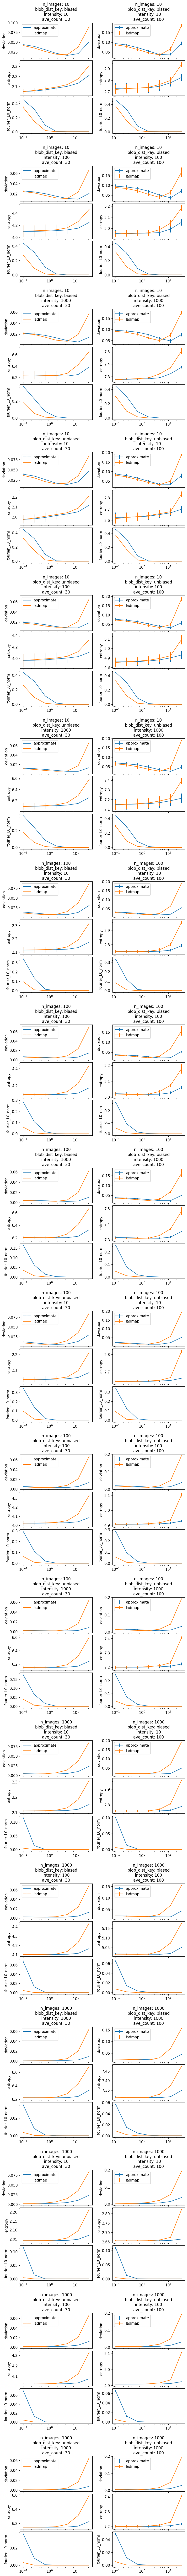

In [6]:
df = estimated_parameters_df[estimated_parameters_df["true_flatfield_id"] == 1]
image_properties = ["n_images", "blob_dist_key", "intensity", "ave_count"]
keys = list(
    set(estimated_parameters_df.keys())
    - {
        "smoothness_flatfield",
        "deviation",
        "true_flatfield_id",
        "image_index",
        "time",
        "rep",
        "entropy",
        "fourier_L0_norm",
        "autotune_cost",
        "time_gpu",
        "time_cpu",
        *image_properties,
    }
)
assert len(keys) == 1

num_imagess = df["ave_count"].unique().tolist()
ncols = len(num_imagess)
grps = list(df.groupby(image_properties))
nrows = (len(grps) - 1) // ncols + 1

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 6 * nrows),
    # gridspec_kw={"hspace": 1.5, "wspace": 1.0},
    dpi=50,
)
summaried_df_data = []

for ii, (image_property, grp0) in enumerate(df.groupby(image_properties)):
    ax = axes[ii // ncols, ii % ncols]
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="100%", pad=0.1, sharex=ax)
    ax3 = divider.append_axes("bottom", size="100%", pad=0.1, sharex=ax)
    for key, grp in grp0.groupby(keys[0]):
        d = {k: v for k, v in zip(image_properties, image_property)}
        d[keys[0]] = key

        min_deviation_smoothness_flatfield = [
            grp1.loc[grp1["deviation"].idxmin()]["smoothness_flatfield"]
            for _, grp1 in grp.groupby("rep")
        ]
        d["min_deviation_smoothness_flatfield_max"] = np.max(
            min_deviation_smoothness_flatfield
        )
        d["min_deviation_smoothness_flatfield_median"] = np.median(
            min_deviation_smoothness_flatfield
        )
        d["min_deviation_smoothness_flatfield_min"] = np.min(
            min_deviation_smoothness_flatfield
        )
        summaried_df_data.append(d)
        for _ax, name in zip(
            [ax, ax2, ax3], ["deviation", "entropy", "fourier_L0_norm"]
        ):
            vals = (
                grp.groupby("smoothness_flatfield")[name]
                .agg(["mean", "std"])
                .reset_index()
            )

            _ax.errorbar(
                vals["smoothness_flatfield"], vals["mean"], vals["std"], label=key
            )
            _ax.set_ylabel(name)

    ax.set_title(
        "\n".join([f"{k}: {v}" for k, v in zip(image_properties, image_property)]),
    )
    ax.legend()
    ax.set_xlabel("smoothness_flatfield")
    ax.set_xscale("log")

summaried_df = pd.DataFrame.from_records(summaried_df_data)

fig.tight_layout()

In [7]:
summaried_df.head()

,n_images,blob_dist_key,intensity,ave_count,fitting_mode,min_deviation_smoothness_flatfield_max,min_deviation_smoothness_flatfield_median,min_deviation_smoothness_flatfield_min
0,10,biased,10,30,approximate,4.641589,4.641589,4.641589
1,10,biased,10,30,ladmap,4.641589,1.778279,1.778279
2,10,biased,10,100,approximate,12.115277,4.641589,4.641589
3,10,biased,10,100,ladmap,4.641589,4.641589,4.641589
4,10,biased,100,30,approximate,12.115277,12.115277,12.115277


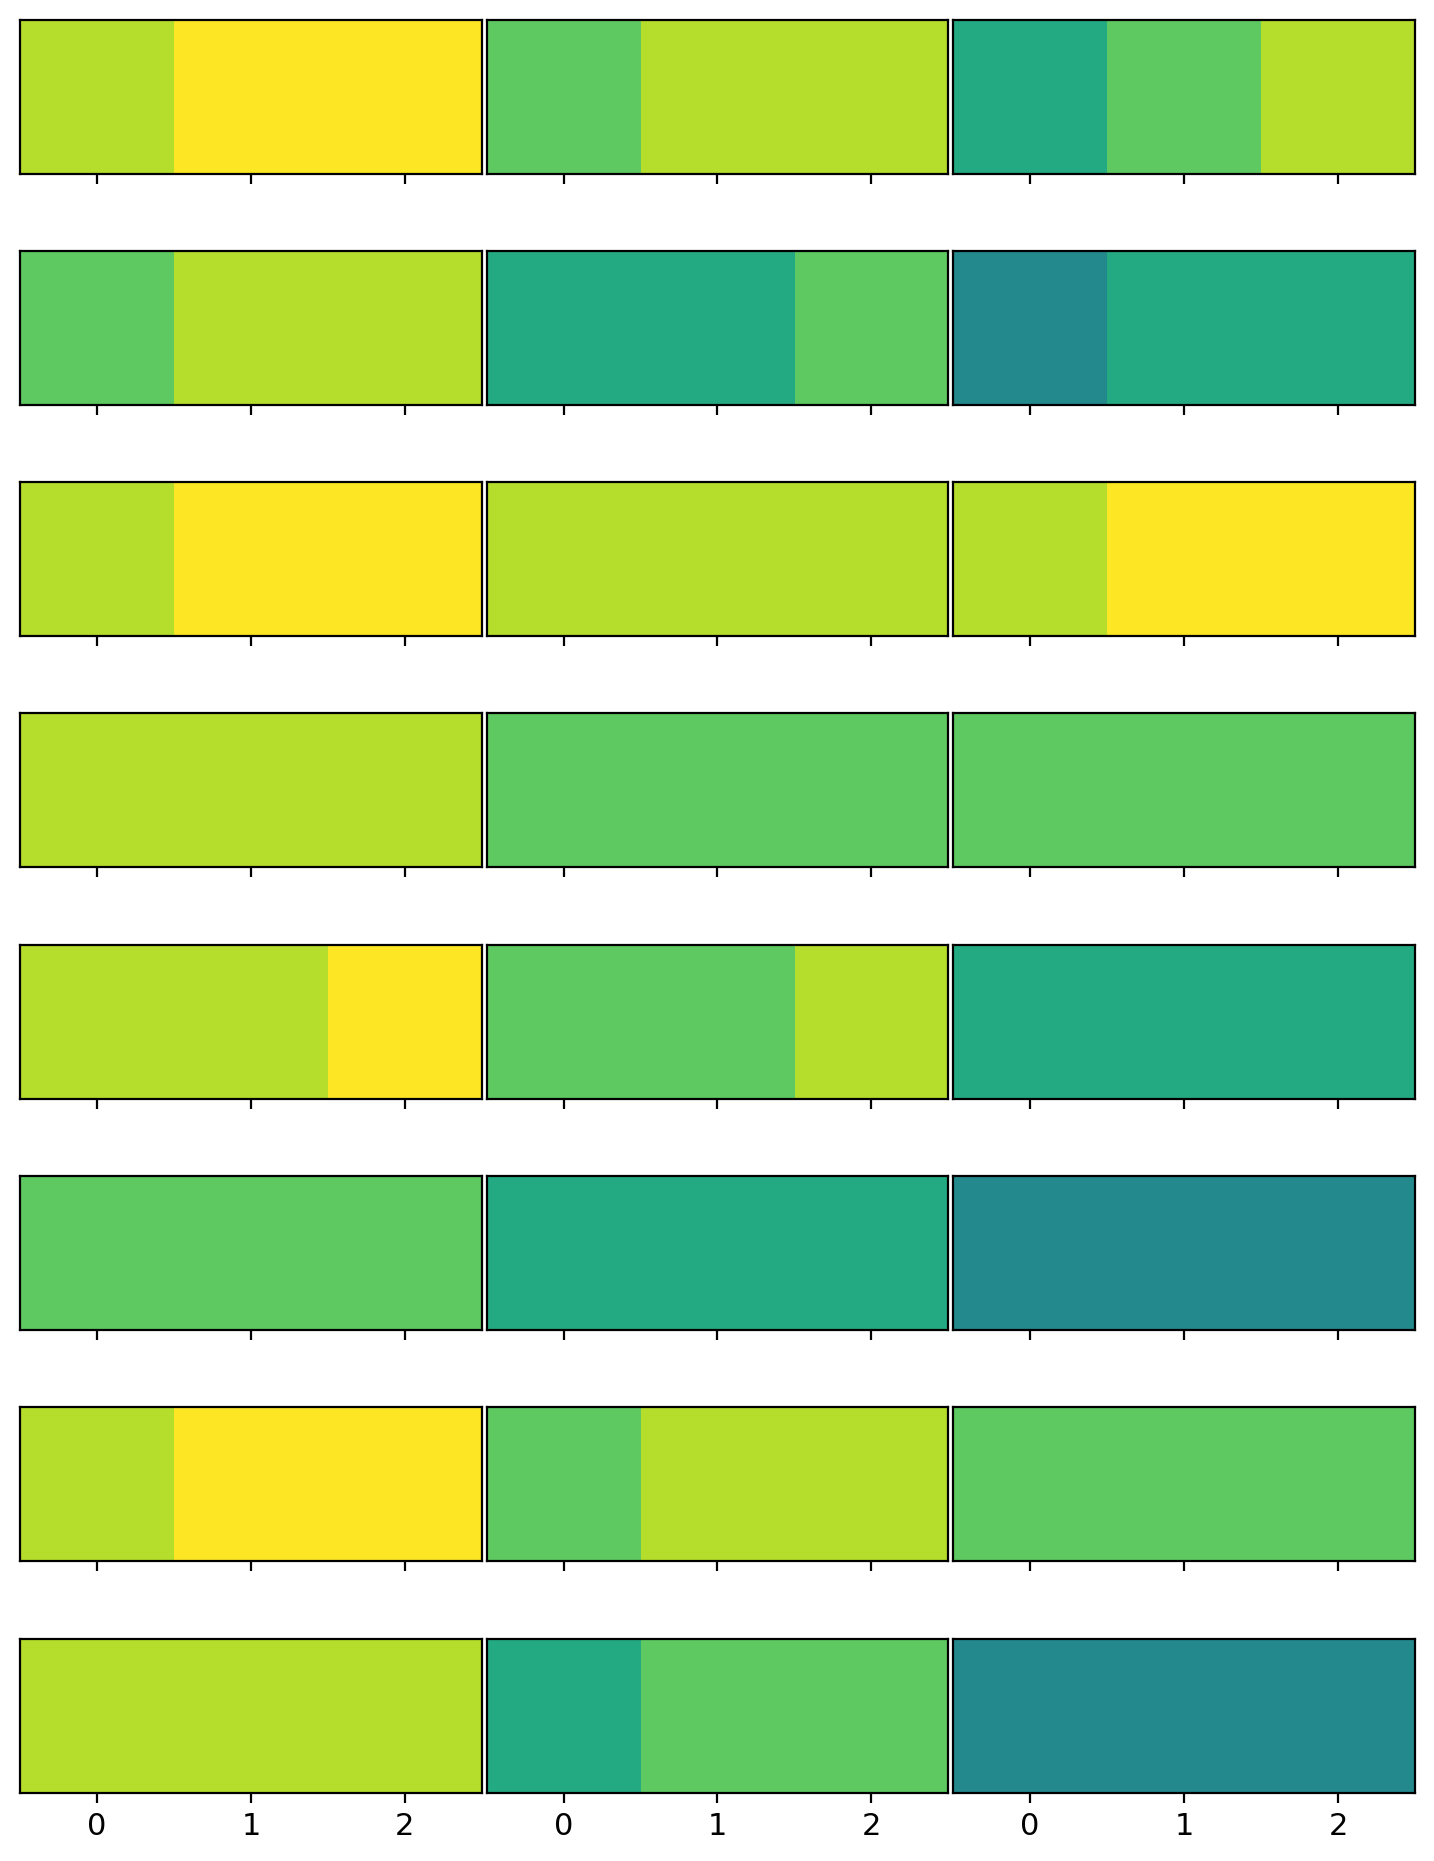

In [8]:
grp0s = list(summaried_df.groupby(["blob_dist_key", "ave_count", "fitting_mode"]))

n_images_count = len(summaried_df["n_images"].unique())
intensities = summaried_df["intensity"].unique()

nrows = len(grp0s)
ncols = n_images_count
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(ncols * 3, nrows * 1.5),
    sharex=True,
    gridspec_kw={"hspace": 0.01, "wspace": 0.01},
)

for row, (image_property, grp0) in enumerate(grp0s):
    grps = list(grp0.groupby("n_images"))
    for col, (n_images, grp) in enumerate(grps):
        ax = axes[row, col]
        df = grp.sort_values("intensity")
        assert np.all(df["intensity"] == intensities)
        # ax.set_xticks(intensities)
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.imshow(
            [np.log10(df["min_deviation_smoothness_flatfield_median"])], vmin=-2, vmax=1
        )

In [9]:
fourier_l0_norm_thresholds = np.linspace(0, 0.1, 10)
fourier_l0_norm_cost_coefs = [1, 2, 3, 5, 10, 20, 30, 50, 100]

In [10]:
def to_autotune_cost(
    entropy_value, n, fourier_l0_norm_threshold, fourier_l0_norm_cost_coef
):
    if n < fourier_l0_norm_threshold:
        fourier_L0_norm_cost = 0
    else:
        fourier_L0_norm_cost = (
            n - fourier_l0_norm_threshold
        ) * fourier_l0_norm_cost_coef
    return entropy_value + fourier_L0_norm_cost


to_autotune_cost = np.vectorize(to_autotune_cost)

all_ress = []
for fourier_l0_norm_threshold, fourier_l0_norm_cost_coef in tqdm(
    list(product(fourier_l0_norm_thresholds, fourier_l0_norm_cost_coefs))
):
    keys = image_properties + ["fitting_mode", "true_flatfield_id"]
    for vals, grp in estimated_parameters_df.groupby(keys):
        deviation_optimal_diffs = []
        for rep, grp2 in grp.groupby("rep"):
            autotune_cost = to_autotune_cost(
                grp2["entropy"],
                grp2["fourier_L0_norm"],
                fourier_l0_norm_threshold,
                fourier_l0_norm_cost_coef,
            )
            optimal_deviation = grp2["deviation"].min()
            estimated_deviation = grp2["deviation"].values[np.argmin(autotune_cost)]

            r = dict(zip(keys, vals))
            r["fourier_l0_norm_threshold"] = fourier_l0_norm_threshold
            r["fourier_l0_norm_cost_coef"] = fourier_l0_norm_cost_coef
            r["optimal_deviation"] = optimal_deviation
            r["estimated_deviation"] = estimated_deviation
            r["rep"] = rep
            all_ress.append(r)
deviation_df = pd.DataFrame.from_records(all_ress)

100%|██████████| 90/90 [00:18<00:00,  4.81it/s]


In [11]:
deviation_df["deviation_diff"] = (
    deviation_df["estimated_deviation"] - deviation_df["optimal_deviation"]
)
deviation_df2 = (
    deviation_df.groupby(
        keys + ["fourier_l0_norm_threshold", "fourier_l0_norm_cost_coef"]
    )
    .agg(["mean"])
    .reset_index()
)

In [12]:
deviation_df2.head()

,n_images,blob_dist_key,intensity,ave_count,fitting_mode,true_flatfield_id,fourier_l0_norm_threshold,fourier_l0_norm_cost_coef,optimal_deviation,estimated_deviation,rep,deviation_diff
,,,,,,,,,mean,mean,mean,mean
0,10,biased,10,30,approximate,0,0.0,1,0.011853,0.019466,2.0,0.007613
1,10,biased,10,30,approximate,0,0.0,2,0.011853,0.014002,2.0,0.002149
2,10,biased,10,30,approximate,0,0.0,3,0.011853,0.012260,2.0,0.000407
3,10,biased,10,30,approximate,0,0.0,5,0.011853,0.012260,2.0,0.000407
4,10,biased,10,30,approximate,0,0.0,10,0.011853,0.012260,2.0,0.000407


In [13]:
import warnings

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_63481/1582183793.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_63481/1582183793.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_63481/1582183793.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_63481/1582183793.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


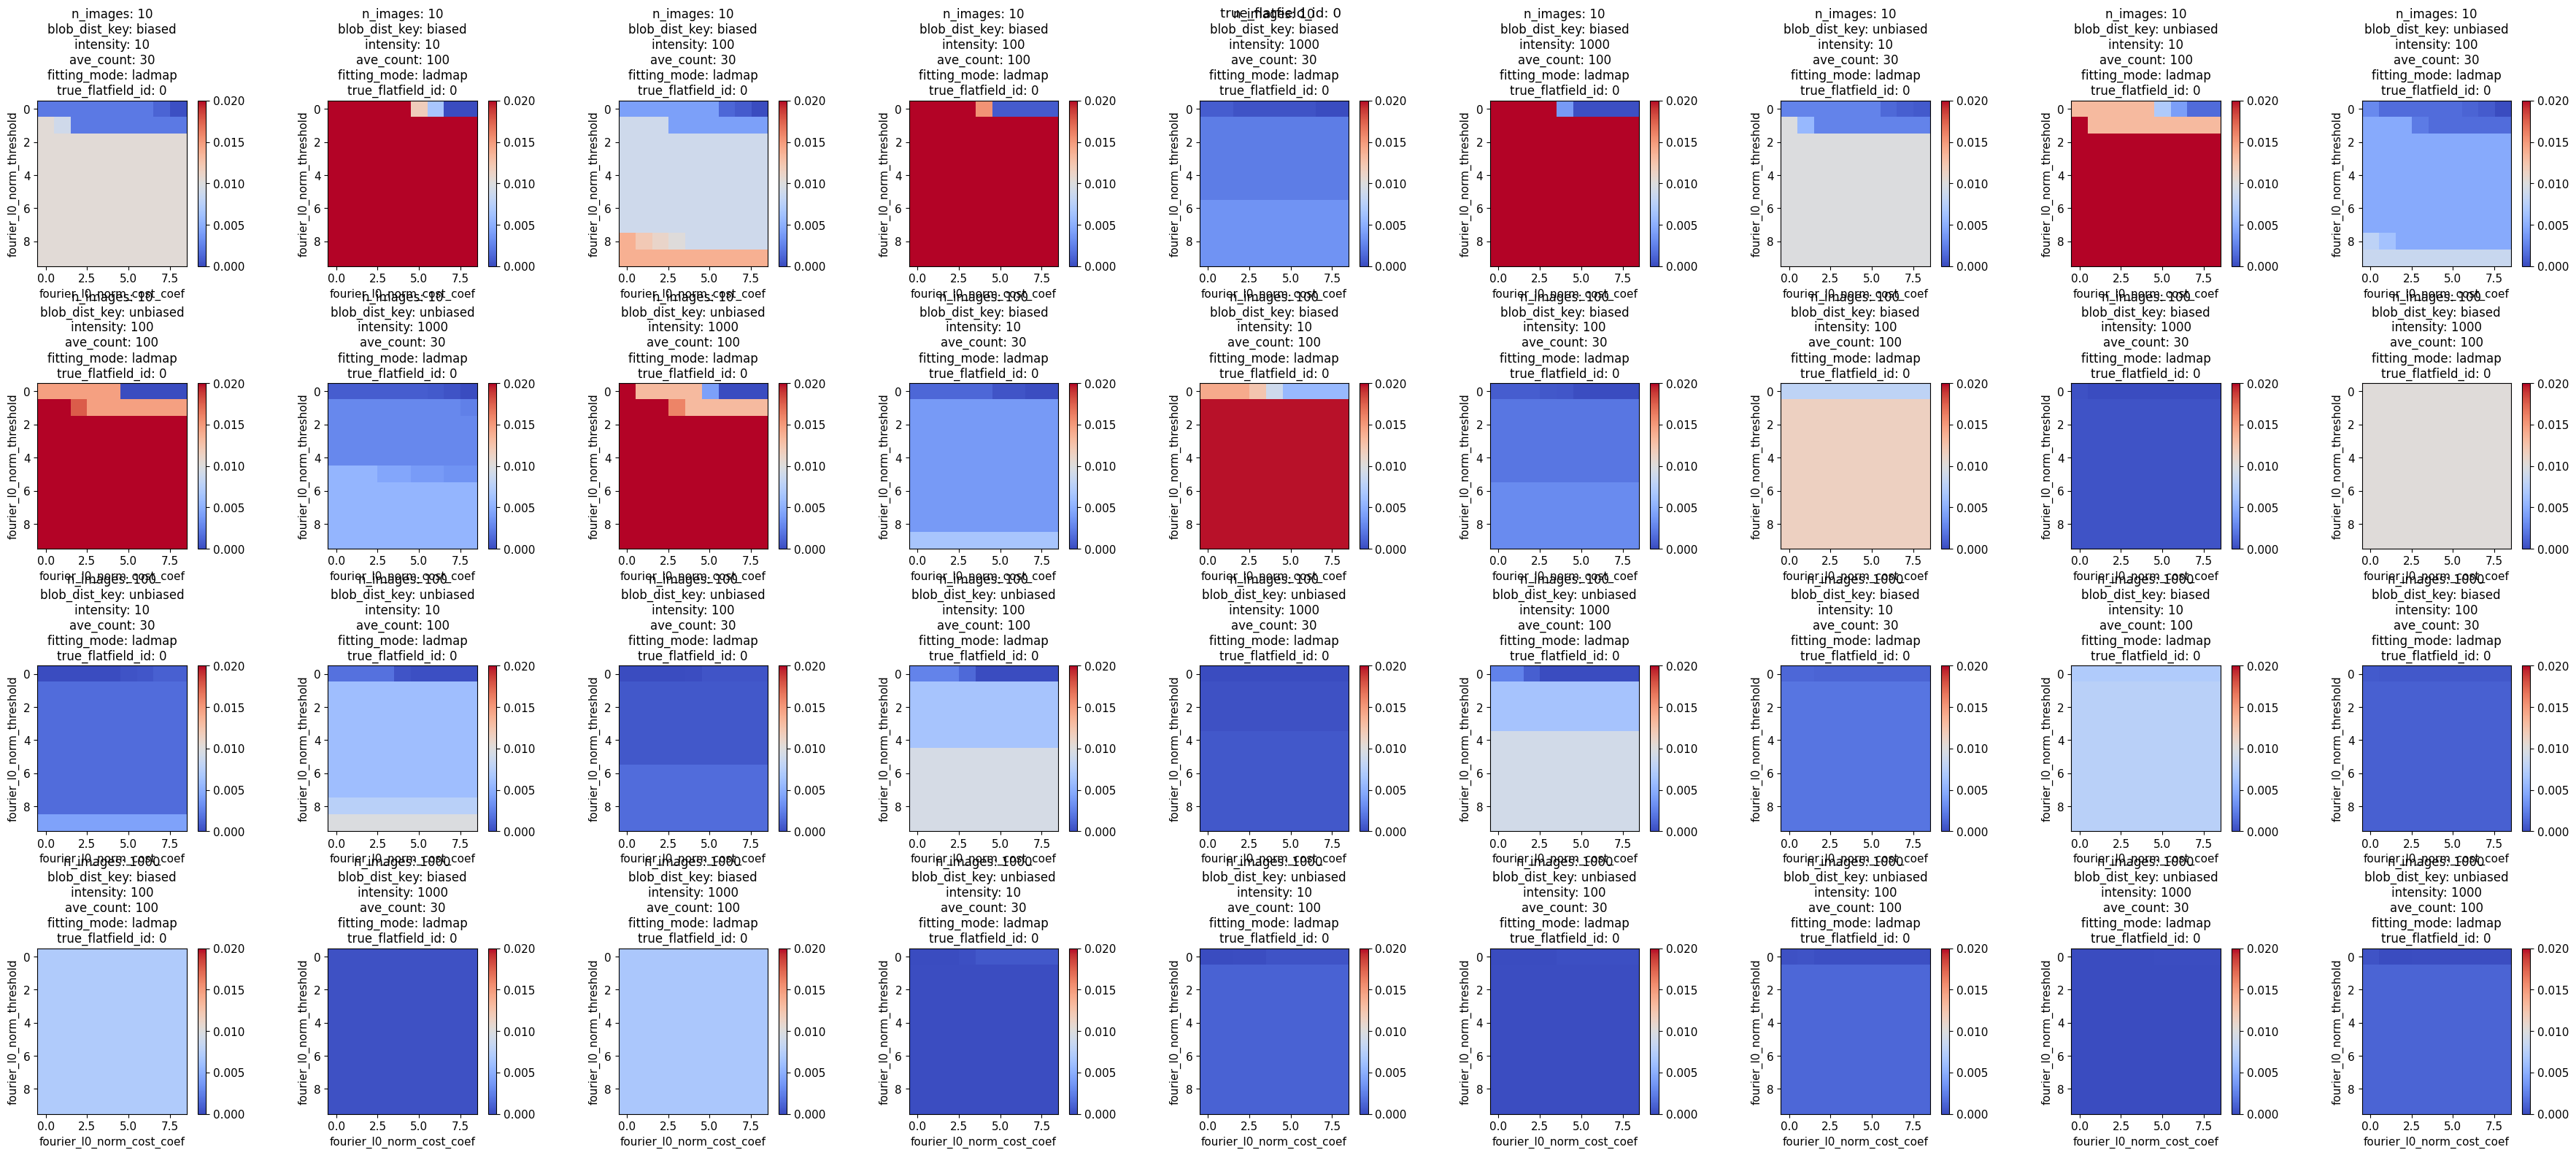

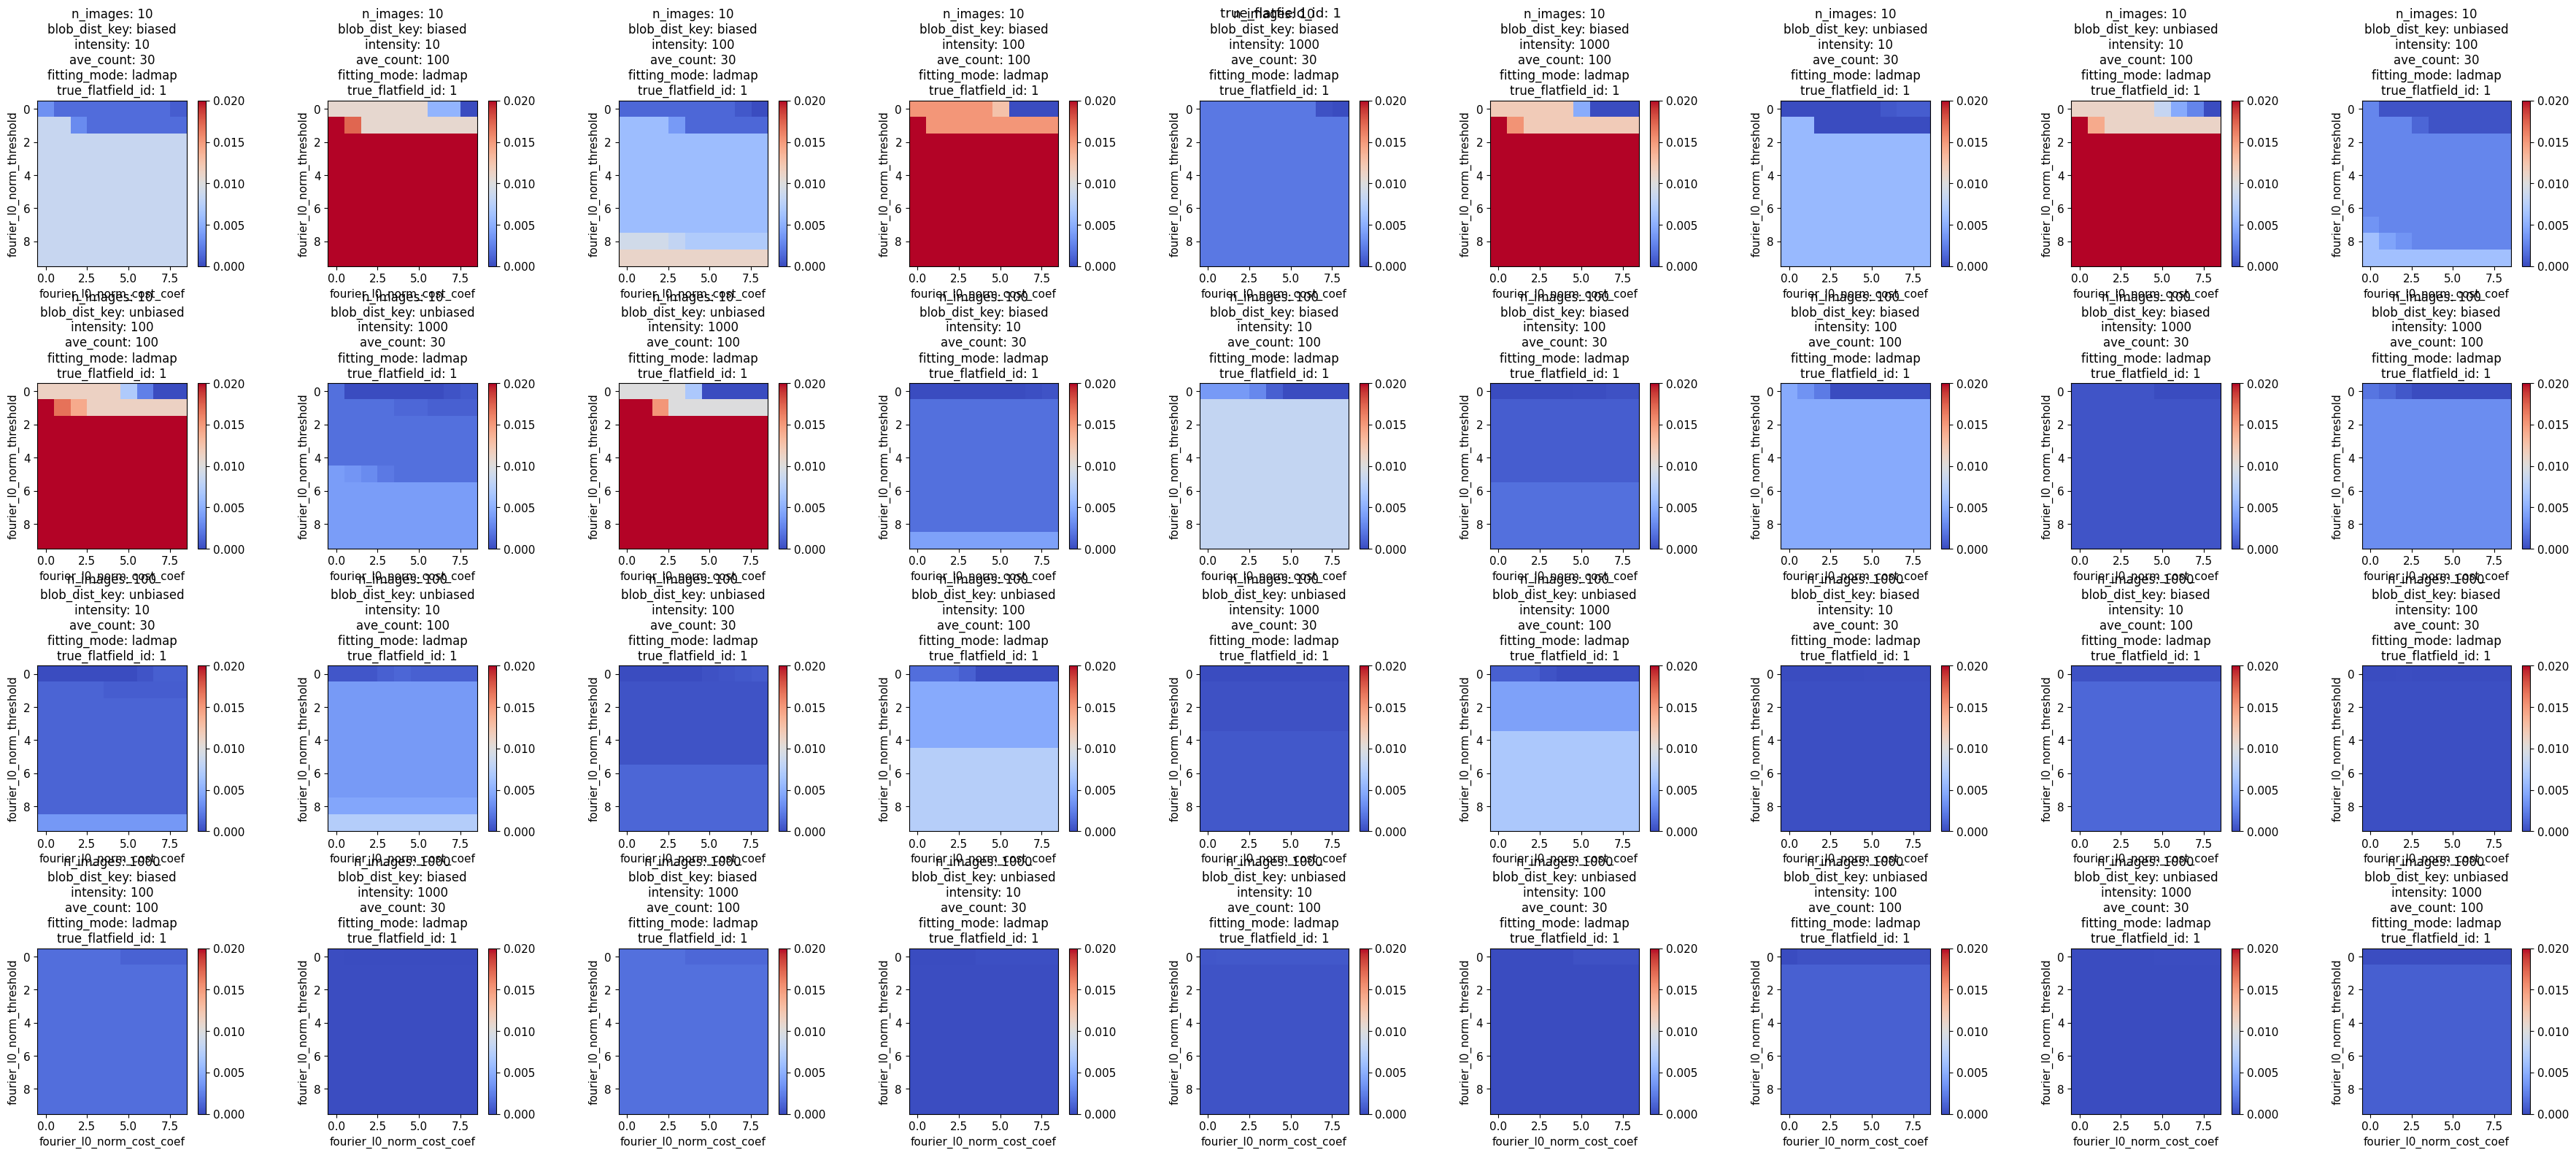

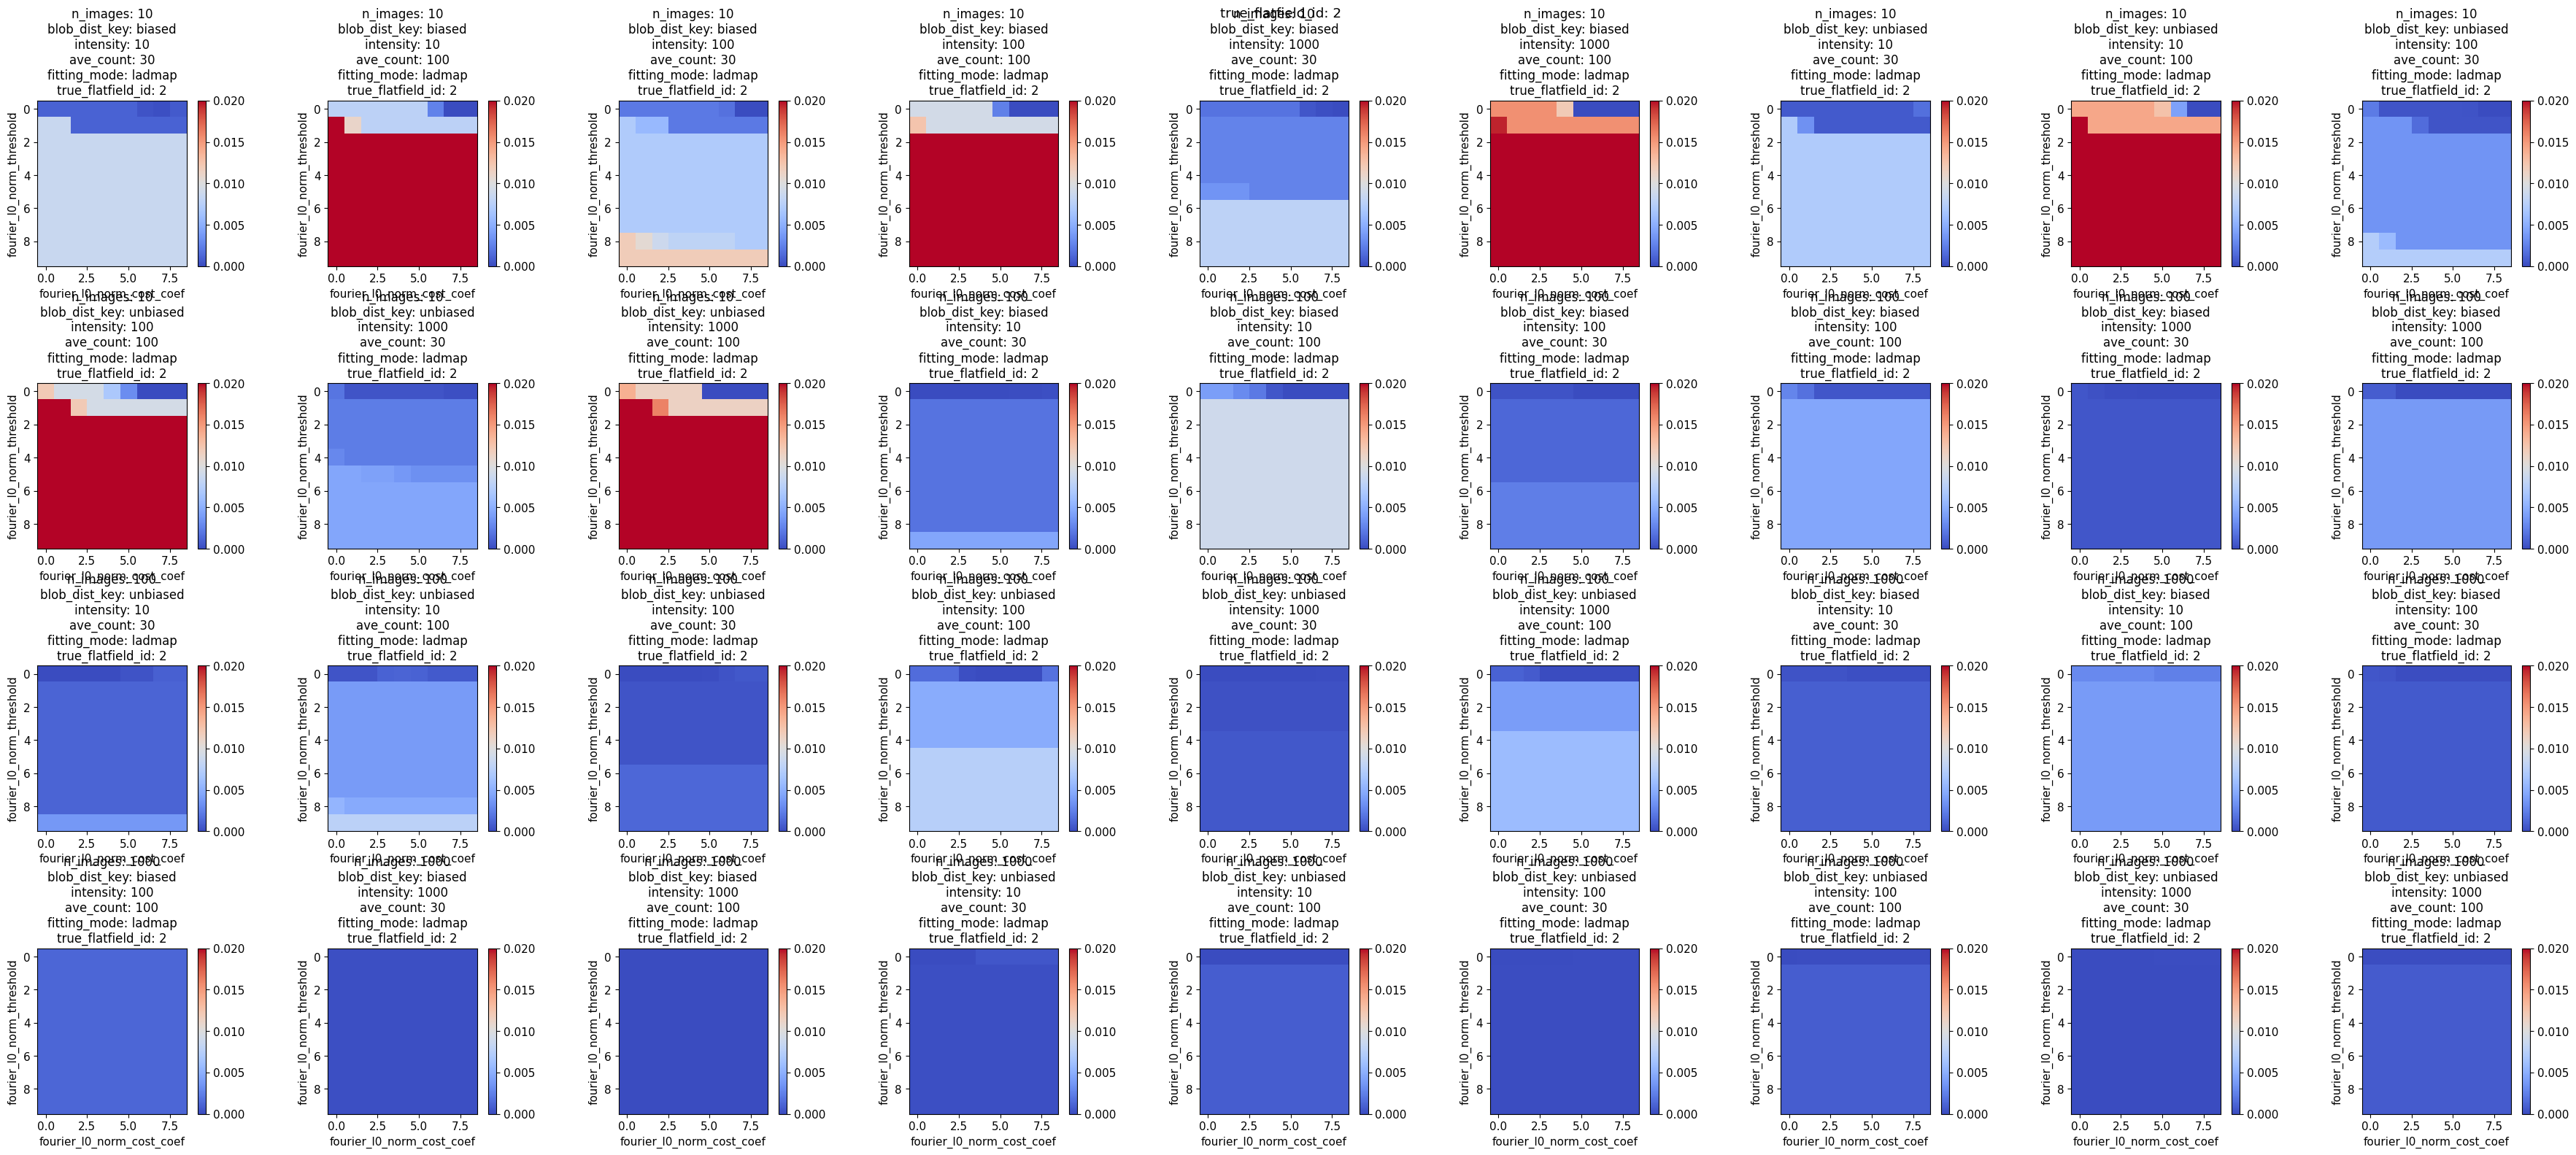

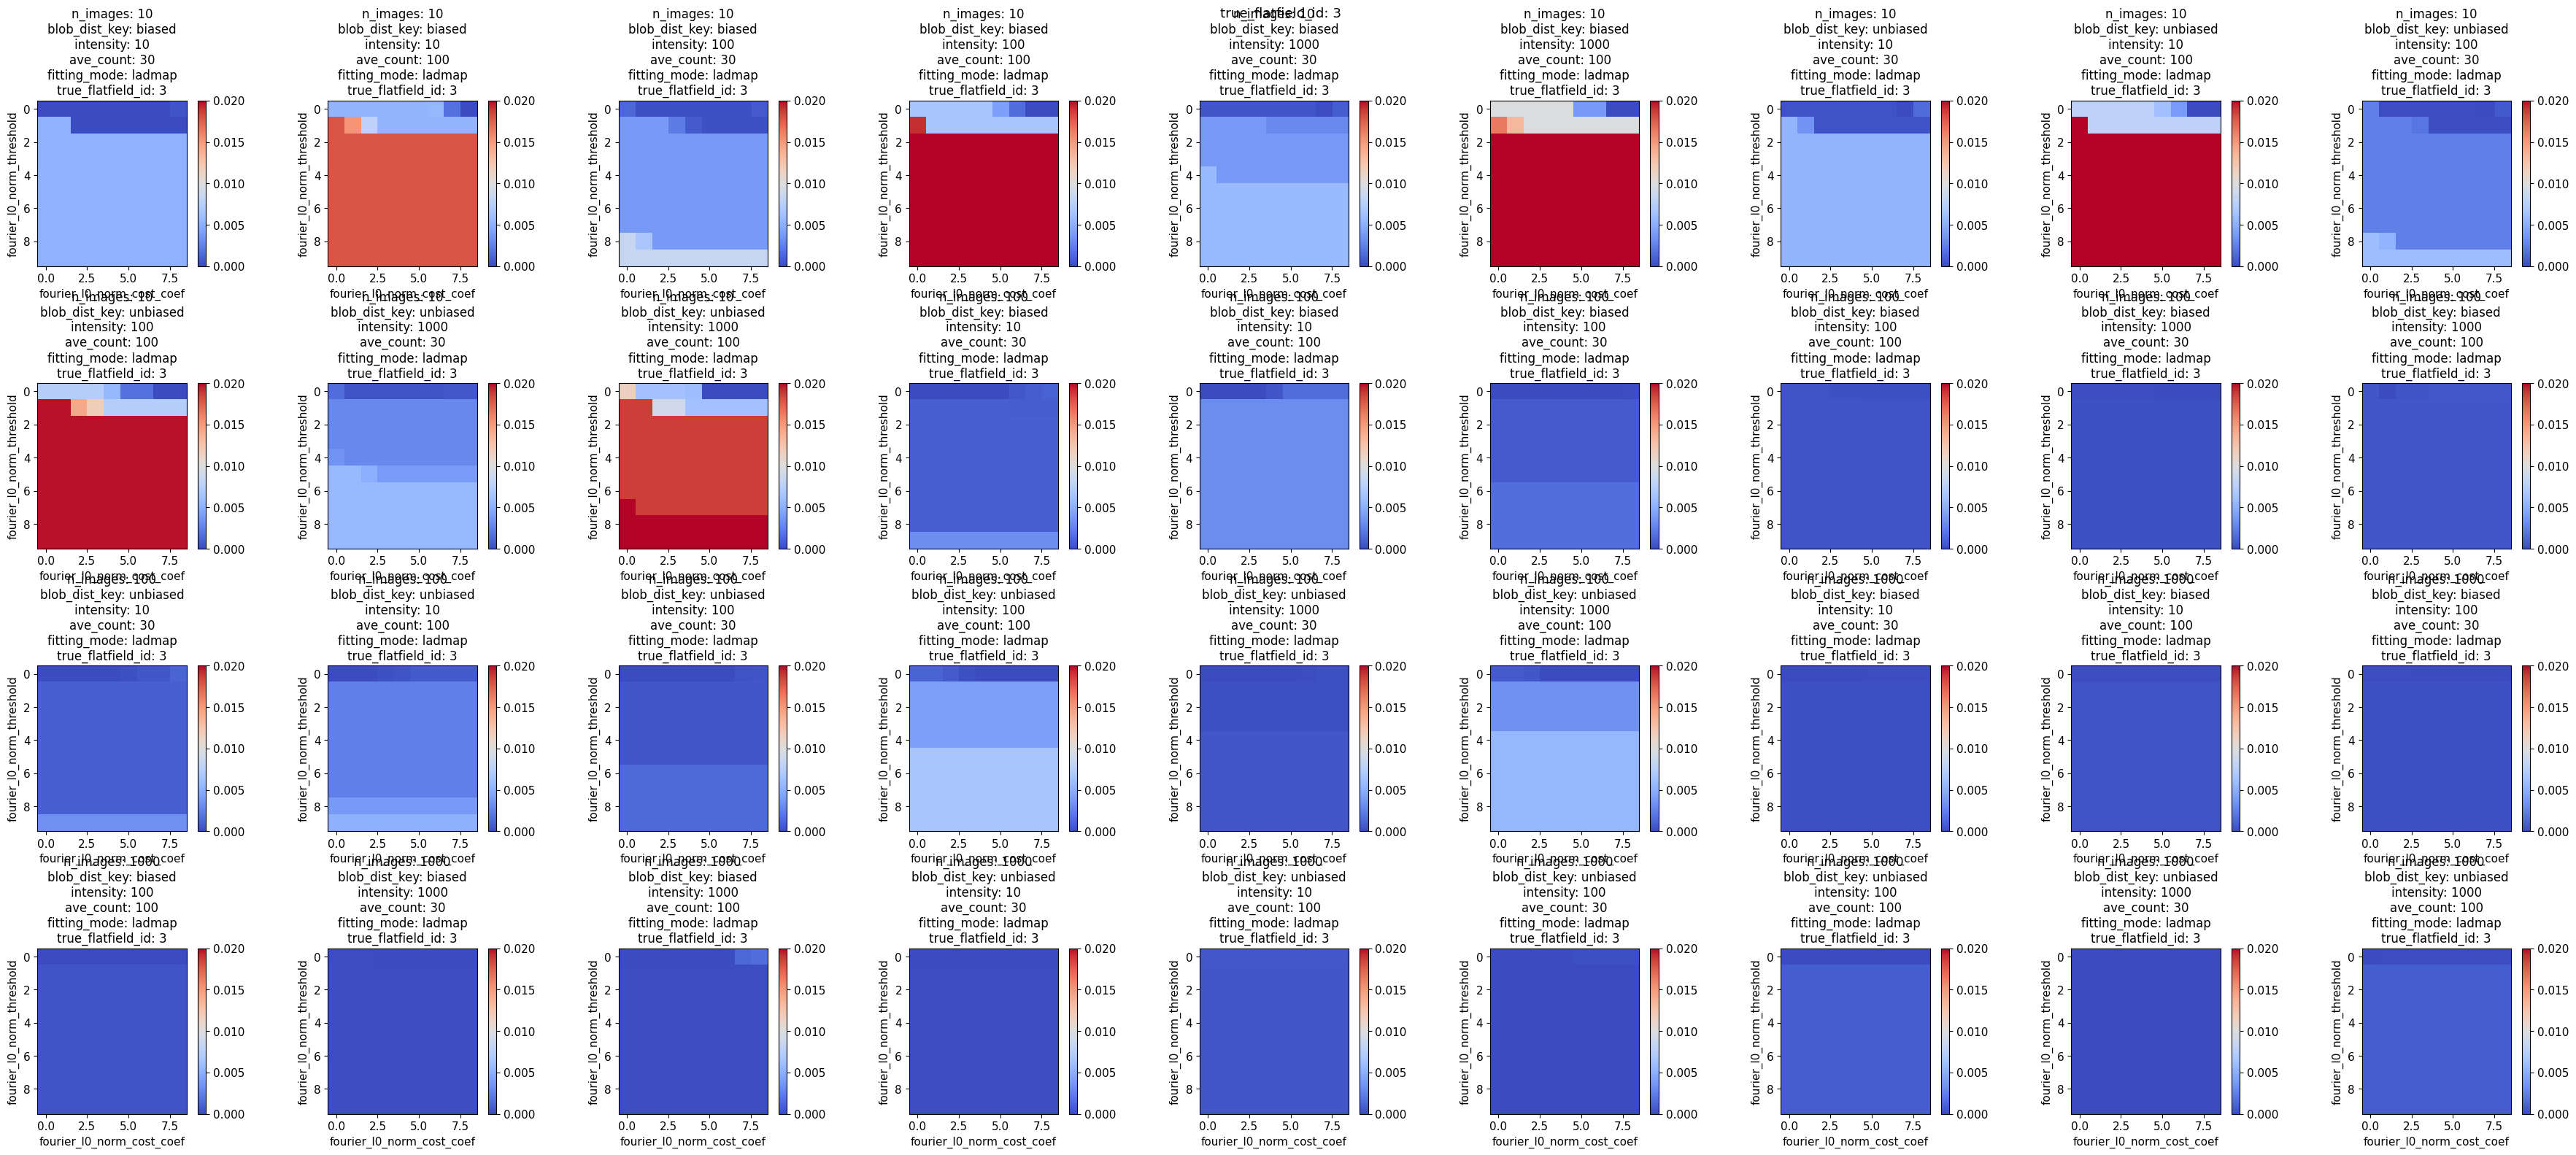

In [14]:
_df = deviation_df2[(deviation_df2["fitting_mode"] == "ladmap")]
for true_flatfield_id, grp0 in _df.groupby("true_flatfield_id"):
    ncols = 9
    nrows = (len(grp0.groupby(keys)) - 1) // ncols + 1
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4 * ncols, 4 * nrows),
        # gridspec_kw={"hspace": 1.5, "wspace": 1.0},
        dpi=50,
    )
    for ax, (vals, grp) in zip(axes.ravel(), grp0.groupby(keys)):
        # Reshape the data
        pivot_df = grp.pivot_table(
            values="deviation_diff",
            index="fourier_l0_norm_threshold",
            columns="fourier_l0_norm_cost_coef",
            fill_value=0,
        )["mean"]

        # Plot the heatmap
        im = ax.imshow(pivot_df, cmap="coolwarm", vmin=0, vmax=0.02)

        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax)

        # Set axis labels and title
        ax.set_xlabel("fourier_l0_norm_cost_coef")
        ax.set_ylabel("fourier_l0_norm_threshold")
        ax.set_title("Heatmap of deviation_diff mean values")

        ax.set_title(
            "\n".join([f"{k}: {v}" for k, v in zip(keys, vals)]),
        )
    fig.suptitle(f"true_flatfield_id: {true_flatfield_id}")
    fig.tight_layout()
    fig.show()

In [15]:
fourier_l0_norm_thresholds

array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ])

In [23]:
fourier_l0_norm_threshold = fourier_l0_norm_thresholds[0]
fourier_l0_norm_cost_coef = sorted(deviation_df2["fourier_l0_norm_cost_coef"].unique())[
    6
]
print(fourier_l0_norm_threshold, fourier_l0_norm_cost_coef)

0.0 30


In [24]:
_df_selected = _df[
    (_df["fourier_l0_norm_threshold"] == fourier_l0_norm_threshold)
    & (_df["fourier_l0_norm_cost_coef"] == fourier_l0_norm_cost_coef)
]
_df_selected

,n_images,blob_dist_key,intensity,ave_count,fitting_mode,true_flatfield_id,fourier_l0_norm_threshold,fourier_l0_norm_cost_coef,optimal_deviation,estimated_deviation,rep,deviation_diff
,,,,,,,,,mean,mean,mean,mean
366,10,biased,10,30,ladmap,0,0.0,30,0.012646,0.014824,2.0,0.002178
456,10,biased,10,30,ladmap,1,0.0,30,0.017827,0.019331,2.0,0.001504
546,10,biased,10,30,ladmap,2,0.0,30,0.017375,0.017710,2.0,0.000335
636,10,biased,10,30,ladmap,3,0.0,30,0.018837,0.018837,2.0,0.000000
1086,10,biased,10,100,ladmap,0,0.0,30,0.023805,0.030426,2.0,0.006620
...,...,...,...,...,...,...,...,...,...,...,...,...
25116,1000,unbiased,1000,30,ladmap,3,0.0,30,0.000666,0.000736,2.0,0.000070
25566,1000,unbiased,1000,100,ladmap,0,0.0,30,0.002874,0.002953,2.0,0.000079
25656,1000,unbiased,1000,100,ladmap,1,0.0,30,0.003645,0.003782,2.0,0.000137


array([[<Axes: title={'center': 'mean'}>]], dtype=object)

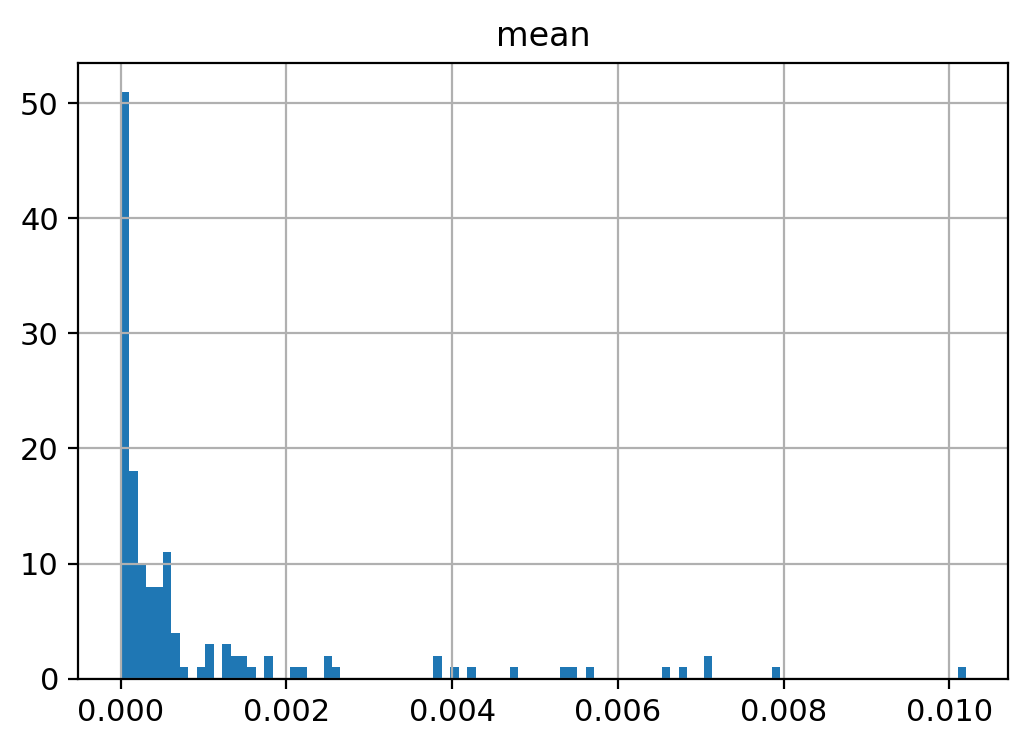

In [25]:
_df_selected["deviation_diff"].hist(bins=100)

array([[<Axes: title={'center': 'mean'}>]], dtype=object)

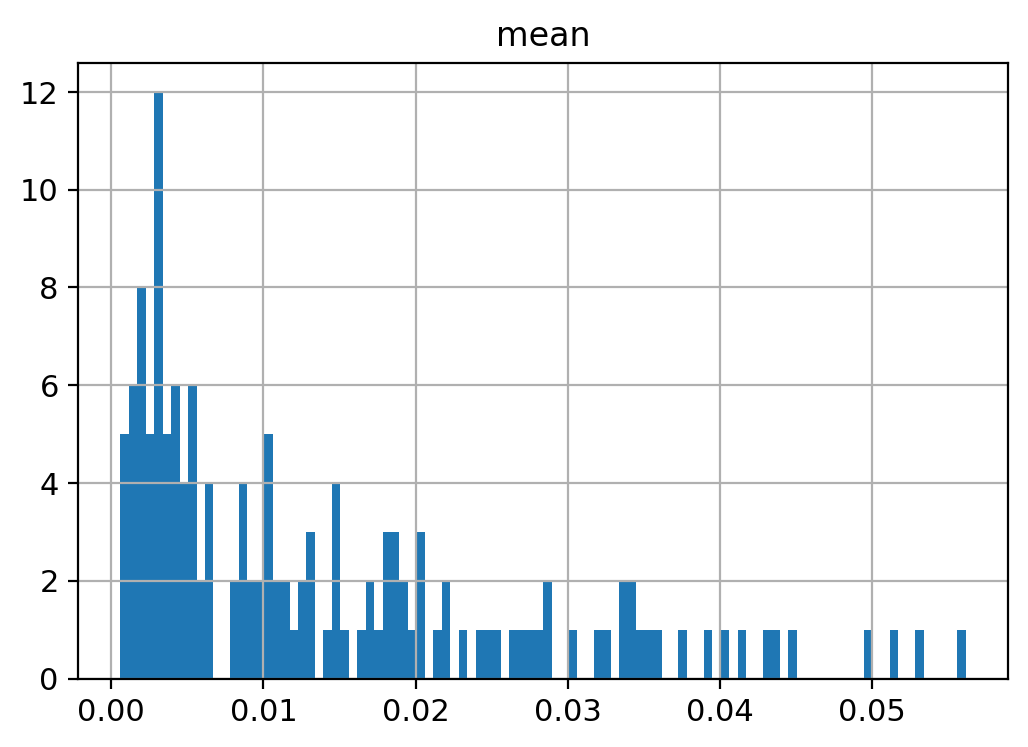

In [26]:
_df_selected["estimated_deviation"].hist(bins=100)

In [19]:
baseline_df = pd.read_csv("baseline_results.csv", index_col=0)

In [20]:
_df2 = pd.merge(
    _df_selected.droplevel(1, axis=1),
    baseline_df,
    on=[
        "n_images",
        "blob_dist_key",
        "intensity",
        "ave_count",
        "true_flatfield_id",
        "rep",
    ],
)

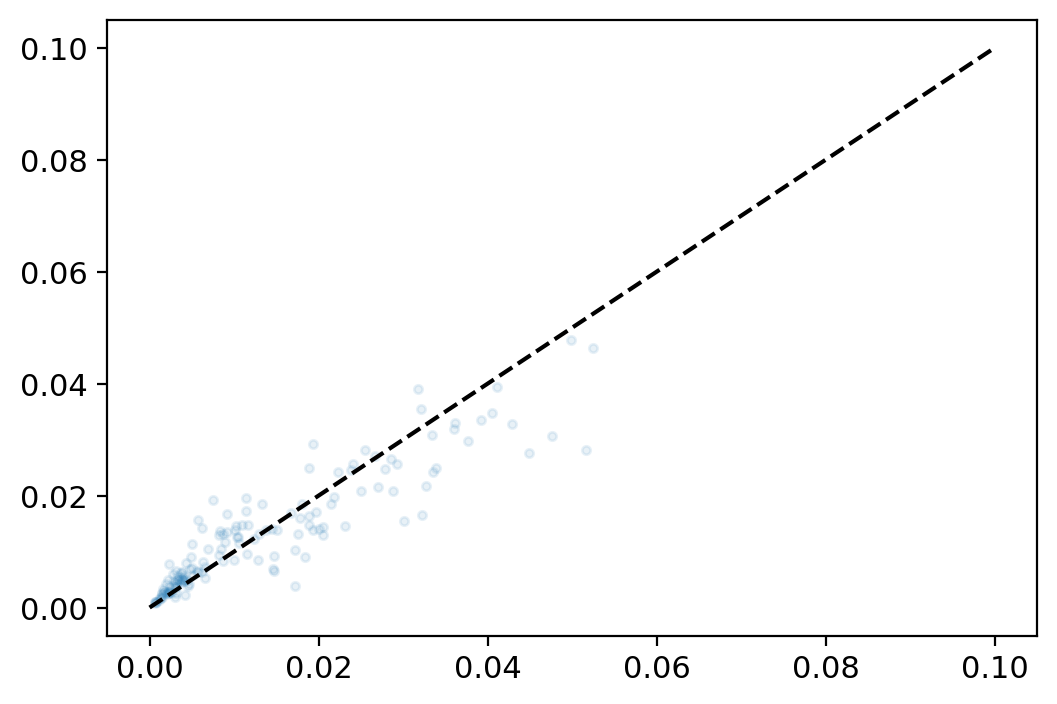

In [27]:
plt.plot(_df2["estimated_deviation"], _df2["deviation"], ".", alpha=0.1)
plt.plot([0, 0.1], [0, 0.1], "k--")

In [31]:
_df_selected.head()

,n_images,blob_dist_key,intensity,ave_count,fitting_mode,true_flatfield_id,fourier_l0_norm_threshold,fourier_l0_norm_cost_coef,optimal_deviation,estimated_deviation,rep,deviation_diff
,,,,,,,,,mean,mean,mean,mean
366,10,biased,10,30,ladmap,0,0.0,30,0.012646,0.014824,2.0,0.002178
456,10,biased,10,30,ladmap,1,0.0,30,0.017827,0.019331,2.0,0.001504
546,10,biased,10,30,ladmap,2,0.0,30,0.017375,0.017710,2.0,0.000335
636,10,biased,10,30,ladmap,3,0.0,30,0.018837,0.018837,2.0,0.000000
1086,10,biased,10,100,ladmap,0,0.0,30,0.023805,0.030426,2.0,0.006620


In [32]:
estimated_parameters_df.head()

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu,deviation,entropy,fourier_L0_norm,autotune_cost
0,0,10,30,10,biased,0,0,ladmap,0.100000,12.788740,NaN,0.039185,2.035007,0.329701,11.926041
1,0,10,30,10,biased,0,0,ladmap,0.261016,1.134672,NaN,0.033143,2.041676,0.150249,6.549148
2,0,10,30,10,biased,0,0,ladmap,0.681292,0.936035,NaN,0.023936,2.054167,0.017933,2.592150
3,0,10,30,10,biased,0,0,ladmap,1.778279,0.949724,NaN,0.014436,2.068040,0.000249,2.075512
4,0,10,30,10,biased,0,0,ladmap,4.641589,1.035547,NaN,0.009749,2.081444,0.000000,2.081444


In [36]:
_df = deviation_df.query(
    "fourier_l0_norm_threshold==0.0 and fourier_l0_norm_cost_coef==30"
)

In [39]:
_df

,n_images,blob_dist_key,intensity,ave_count,fitting_mode,true_flatfield_id,fourier_l0_norm_threshold,fourier_l0_norm_cost_coef,optimal_deviation,estimated_deviation,rep,deviation_diff
8640,10,biased,10,30,approximate,0,0.0,30,0.010901,0.011521,0,0.000620
8641,10,biased,10,30,approximate,0,0.0,30,0.010266,0.010266,1,0.000000
8642,10,biased,10,30,approximate,0,0.0,30,0.009844,0.009844,2,0.000000
8643,10,biased,10,30,approximate,0,0.0,30,0.015444,0.015444,3,0.000000
8644,10,biased,10,30,approximate,0,0.0,30,0.012811,0.014224,4,0.001413
...,...,...,...,...,...,...,...,...,...,...,...,...
10075,1000,unbiased,1000,100,ladmap,3,0.0,30,0.003196,0.003196,0,0.000000
10076,1000,unbiased,1000,100,ladmap,3,0.0,30,0.003004,0.003235,1,0.000231
10077,1000,unbiased,1000,100,ladmap,3,0.0,30,0.003522,0.003661,2,0.000139
10078,1000,unbiased,1000,100,ladmap,3,0.0,30,0.002832,0.003185,3,0.000353


In [43]:
df2s = []
for ks, grp in estimated_parameters_df.groupby(
    [
        "true_flatfield_id",
        "intensity",
        "ave_count",
        "n_images",
        "blob_dist_key",
        "fitting_mode",
        "rep",
    ]
):
    row = grp[grp["autotune_cost"] == grp["autotune_cost"].min()]
    df2s.append(row)
df2 = pd.concat(df2s)

In [44]:
df2

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu,deviation,entropy,fourier_L0_norm,autotune_cost
11,0,10,30,10,biased,0,0,approximate,4.641589,0.971388,NaN,0.011521,2.071953,0.000000,2.071953
25,0,10,30,10,biased,1,1,approximate,4.641589,0.941281,NaN,0.010266,2.092393,0.000000,2.092393
39,0,10,30,10,biased,2,2,approximate,4.641589,0.947217,NaN,0.009844,2.025968,0.000000,2.025968
53,0,10,30,10,biased,3,3,approximate,4.641589,0.938916,NaN,0.015444,2.055270,0.000062,2.057138
67,0,10,30,10,biased,4,4,approximate,4.641589,0.944137,NaN,0.014224,2.074451,0.000062,2.076319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10012,3,1000,100,1000,unbiased,0,715,ladmap,0.681292,1.569692,NaN,0.003196,7.211840,0.000000,7.211840
10026,3,1000,100,1000,unbiased,1,716,ladmap,0.681292,1.504088,NaN,0.003235,7.210032,0.000000,7.210032
10040,3,1000,100,1000,unbiased,2,717,ladmap,0.681292,1.513416,NaN,0.003661,7.204976,0.000000,7.204976
10054,3,1000,100,1000,unbiased,3,718,ladmap,0.681292,1.620969,NaN,0.003185,7.207494,0.000000,7.207494


In [48]:
_df3 = pd.merge(df2, _df)
_df3.head()

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu,deviation,entropy,fourier_L0_norm,autotune_cost,fourier_l0_norm_threshold,fourier_l0_norm_cost_coef,optimal_deviation,estimated_deviation,deviation_diff
0,0,10,30,10,biased,0,0,approximate,4.641589,0.971388,NaN,0.011521,2.071953,0.000000,2.071953,0.0,30,0.010901,0.011521,0.000620
1,0,10,30,10,biased,1,1,approximate,4.641589,0.941281,NaN,0.010266,2.092393,0.000000,2.092393,0.0,30,0.010266,0.010266,0.000000
2,0,10,30,10,biased,2,2,approximate,4.641589,0.947217,NaN,0.009844,2.025968,0.000000,2.025968,0.0,30,0.009844,0.009844,0.000000
3,0,10,30,10,biased,3,3,approximate,4.641589,0.938916,NaN,0.015444,2.055270,0.000062,2.057138,0.0,30,0.015444,0.015444,0.000000
4,0,10,30,10,biased,4,4,approximate,4.641589,0.944137,NaN,0.014224,2.074451,0.000062,2.076319,0.0,30,0.012811,0.014224,0.001413


In [50]:
assert np.allclose(_df3["estimated_deviation"], _df3["deviation"])